<a href="https://colab.research.google.com/github/vadhri/hpc-notebook/blob/main/FourierTransforms_1D_2D_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np

1D FFT

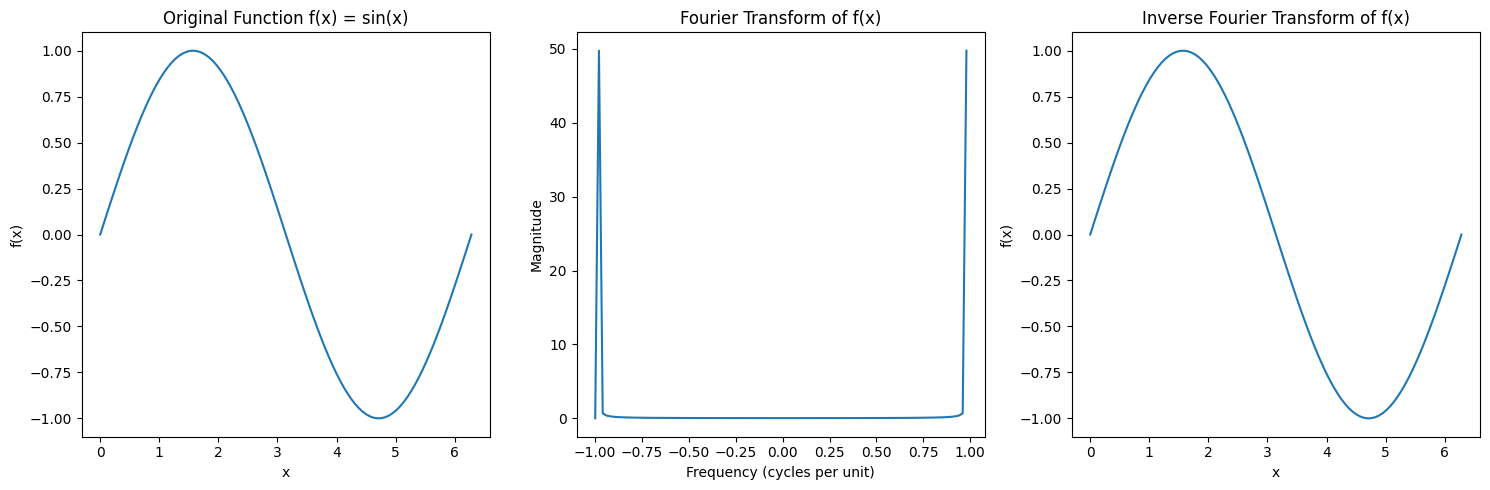

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def f(x):
  return np.sin(x)

# Sample data
x = np.linspace(0, 2 * np.pi, 100)
y = f(x)

# Plot original function
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x, y)
plt.title('Original Function f(x) = sin(x)')
plt.xlabel('x')
plt.ylabel('f(x)')


def my_fft(y):
    N = len(y)
    Y = [0] * N
    for k in range(N):
        for n in range(N):
            Y[k] += y[n] * np.exp(-1j * 2 * np.pi * k * n / N)
    return Y

def my_fftfreq(N):
    f = [0] * N
    for i in range(N):
      f[i] = (i - N // 2) / (N / 2) if N % 2 == 0 else i / N
    return f


# Fourier transform
Y = my_fft(y)
freq = my_fftfreq(len(y))

# Plot Fourier transform
plt.subplot(1, 3, 2)
plt.plot(freq, np.abs(Y))
plt.title('Fourier Transform of f(x)')
plt.xlabel('Frequency (cycles per unit)')
plt.ylabel('Magnitude')

def my_ifft(Y):
    N = len(Y)
    y = [0] * N
    for n in range(N):
        for k in range(N):
            y[n] += Y[k] * np.exp(1j * 2 * np.pi * k * n / N)
        y[n] /= N
    return y


# Inverse Fourier transform
y_inv = my_ifft(Y)

# Plot Inverse Fourier transform
plt.subplot(1, 3, 3)
plt.plot(x, np.real(y_inv))
plt.title('Inverse Fourier Transform of f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')


plt.tight_layout()
plt.show()


In [ ]:
%%writefile fft.cu
#include <stdio.h>
#include <cuComplex.h>
#include <math.h>
#include <cuda_runtime.h>

#define THREADS_PER_BLOCK 32

__global__ void dftKernel(cuComplex *y, cuComplex *Y, int N, int inverse) {
    int k = threadIdx.x + blockIdx.x * blockDim.x;
    if (k >= N) return;

    cuComplex sum = make_cuComplex(0.0f, 0.0f);
    float sign = inverse ? 1.0f : -1.0f;

    for (int n = 0; n < N; n++) {
        float angle = sign * 2.0f * M_PI * k * n / N;
        cuComplex expTerm = make_cuComplex(cosf(angle), sinf(angle));

        cuComplex yn = y[n];  // Copy to local variable for better memory access
        sum = cuCaddf(sum, cuCmulf(yn, expTerm));
    }

    if (inverse) {
        sum.x /= N;
        sum.y /= N;
    }

    Y[k] = sum;
}

void computeDFT(cuComplex *d_y, cuComplex *d_Y, int N, int inverse) {
    int blocks = (N + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK;
    dftKernel<<<blocks, THREADS_PER_BLOCK>>>(d_y, d_Y, N, inverse);
    cudaDeviceSynchronize();  // Ensures execution finishes
}

void checkCudaError(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s - %s\n", msg, cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
}

int main() {
    int N = 100; // Can be adjusted
    cuComplex *h_y = (cuComplex*)malloc(N * sizeof(cuComplex));
    cuComplex *h_Y = (cuComplex*)malloc(N * sizeof(cuComplex));
    cuComplex *h_y_inv = (cuComplex*)malloc(N * sizeof(cuComplex));

    cuComplex *d_y, *d_Y;
    checkCudaError(cudaMalloc((void**)&d_y, N * sizeof(cuComplex)), "cudaMalloc d_y failed");
    checkCudaError(cudaMalloc((void**)&d_Y, N * sizeof(cuComplex)), "cudaMalloc d_Y failed");

    FILE *dftFile = fopen("dft_output.txt", "w");
    FILE *idftFile = fopen("idft_output.txt", "w");

    // Initialize input signal f(x) = sin(x)
    double start = 0.0;
    double end = 2.0 * M_PI;
    double step = (end - start) / (N - 1);

    for (int i = 0; i < N; i++) {
        float x = start + i * step;
        h_y[i] = make_cuComplex(sinf(x), 0);
    }
    checkCudaError(cudaMemcpy(d_y, h_y, N * sizeof(cuComplex), cudaMemcpyHostToDevice), "cudaMemcpy Host->Device failed");

    // Compute DFT
    computeDFT(d_y, d_Y, N, 0);
    checkCudaError(cudaMemcpy(h_Y, d_Y, N * sizeof(cuComplex), cudaMemcpyDeviceToHost), "cudaMemcpy Device->Host failed");

    for (int i = 0; i < N; i++) {
        fprintf(dftFile, "%f, %f\n", i, cuCrealf(h_Y[i]), cuCimagf(h_Y[i]));
    }

    // Compute Inverse DFT
    computeDFT(d_Y, d_y, N, 1);
    checkCudaError(cudaMemcpy(h_y_inv, d_y, N * sizeof(cuComplex), cudaMemcpyDeviceToHost), "cudaMemcpy Device->Host failed");

    for (int i = 0; i < N; i++) {
        fprintf(idftFile, "%f, %f\n", i, cuCrealf(h_y_inv[i]), cuCimagf(h_y_inv[i]));
    }

    fclose(dftFile);
    fclose(idftFile);

    // print last cu error
    cudaError_t cudaErr = cudaGetLastError();
    if (cudaErr != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(cudaErr));
    }

    // Free memory
    free(h_y);
    free(h_Y);
    free(h_y_inv);
    cudaFree(d_y);
    cudaFree(d_Y);

    return 0;
}

Writing fft.cu


In [ ]:
!nvcc fft.cu -arch=sm_75 -o fft -lm
!./fft 16


fft.cu: In function ‘int main()’:
fft.cu:73:18: warning: format ‘%f’ expects argument of type ‘double’, but argument 3 has type ‘int’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat=-Wformat=]8;;]
   73 |         fprintf(dftFile, "%f, %f\n", i, cuCrealf(h_Y[i]), cuCimagf(h_Y[i]));
      |                  ^~~~~~~~~~  ~
      |                              |
      |                              int
fft.cu:73:18: warning: too many arguments for format []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat-extra-args-Wformat-extra-args]8;;]
fft.cu:81:19: warning: format ‘%f’ expects argument of type ‘double’, but argument 3 has type ‘int’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat=-Wformat=]8;;]
   81 |         fprintf(idftFile, "%f, %f\n", i, cuCrealf(h_y_inv[i]), cuCimagf(h_y_inv[i]));
      |                   ^~~~~~~~~~  ~
      |                               |
      |                          

In [ ]:
import numpy as np

# Load DFT values from file
dft_values = []
with open('dft_output.txt', 'r') as f:
    for line in f:
        real, imag = map(float, line.split(','))
        dft_values.append(complex(real, imag))


# Load IDFT values from file
idft_values = []
with open('idft_output.txt', 'r') as f:
    for line in f:
        real, imag = map(float, line.split(','))
        idft_values.append(complex(real, imag))

if np.all(np.isclose(Y,dft_values, atol=1e-3)):
  print(" All values close, (Y, dft_values) ")

if np.all(np.isclose(idft_values,y_inv, atol=1e-3)):
  print(" All values close, (idft_values, y_inv) ")

 All values close, (Y, dft_values) 
 All values close, (idft_values, y_inv) 


### 2D FFT

Time taken:  58.08007478713989


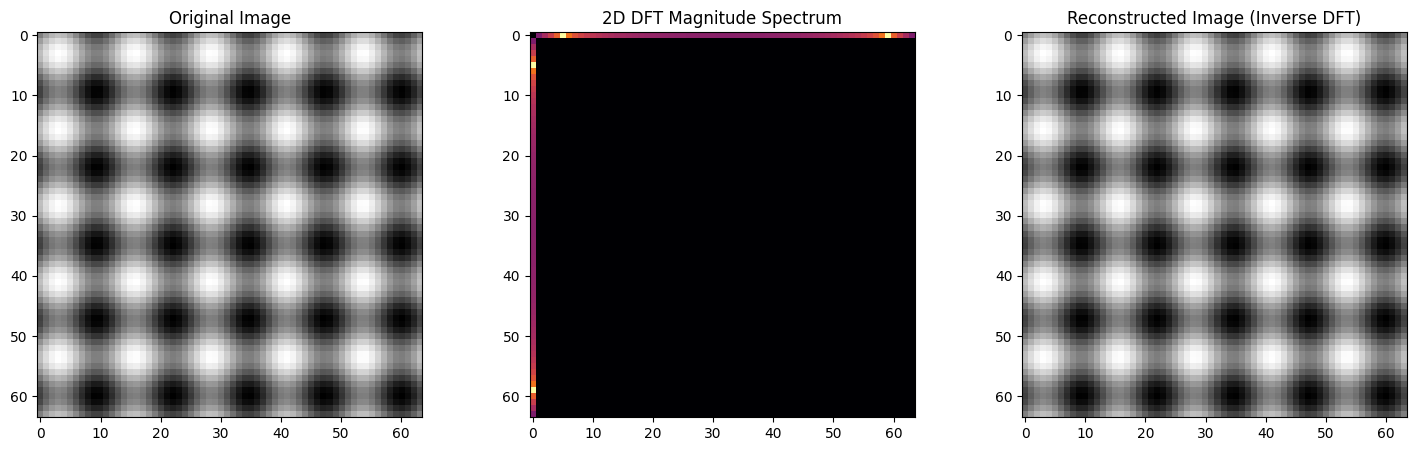

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Generate a 2D sine wave pattern as the input image
N = 64  # Image size (NxN) (smaller for performance reasons)
x = np.linspace(0, 2 * np.pi, N)
y = np.linspace(0, 2 * np.pi, N)
X, Y = np.meshgrid(x, y)
image = np.sin(5 * X) + np.sin(5 * Y)  # Test image

def dft2D(image):
    N, M = image.shape
    dft_result = np.zeros((N, M), dtype=complex)

    for u in range(N):
        for v in range(M):
            sum_val = 0
            for x in range(N):
                for y in range(M):
                    angle = -2j * np.pi * ((u * x / N) + (v * y / M))
                    sum_val += image[x, y] * np.exp(angle)
            dft_result[u, v] = sum_val
    return dft_result

def idft2D(dft_result):
    N, M = dft_result.shape
    image_reconstructed = np.zeros((N, M), dtype=complex)

    for x in range(N):
        for y in range(M):
            sum_val = 0
            for u in range(N):
                for v in range(M):
                    angle = 2j * np.pi * ((u * x / N) + (v * y / M))
                    sum_val += dft_result[u, v] * np.exp(angle)
            image_reconstructed[x, y] = sum_val / (N * M)
    return image_reconstructed.real  # Take real part

# Compute 2D DFT and Inverse DFT
# take start and end time and make diff
start = time.time()
dft_result = dft2D(image)
magnitude_spectrum = np.log1p(np.abs(dft_result))  # Log scale for visualization
image_reconstructed = idft2D(dft_result)
end = time.time()
print("Time taken: ", end - start)
# Plot all results
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(magnitude_spectrum, cmap='inferno')
ax[1].set_title('2D DFT Magnitude Spectrum')

ax[2].imshow(image_reconstructed, cmap='gray')
ax[2].set_title('Reconstructed Image (Inverse DFT)')

plt.show()

In [ ]:
%%writefile fft2d.cu

#include <stdio.h>
#include <cuComplex.h>
#include <math.h>
#include <cuda_runtime.h>

#define THREADS_PER_BLOCK 16  // 2D block size (16x16)

__global__ void dft2DKernel(cuComplex *input, cuComplex *output, int N, int M, int inverse) {
    int u = threadIdx.x + blockIdx.x * blockDim.x;
    int v = threadIdx.y + blockIdx.y * blockDim.y;

    if (u >= N || v >= M) return;

    cuComplex sum = make_cuComplex(0.0f, 0.0f);
    float sign = inverse ? 1.0f : -1.0f;

    for (int x = 0; x < N; x++) {
        for (int y = 0; y < M; y++) {
            float angle = sign * 2.0f * M_PI * ((float)(u * x) / N + (float)(v * y) / M);
            cuComplex expTerm = make_cuComplex(cosf(angle), sinf(angle));

            cuComplex val = input[x * M + y];  // Flattened 2D index
            sum = cuCaddf(sum, cuCmulf(val, expTerm));
        }
    }

    if (inverse) {
        sum.x /= (N * M);
        sum.y /= (N * M);
    }

    output[u * M + v] = sum;
}

void computeDFT2D(cuComplex *d_input, cuComplex *d_output, int N, int M, int inverse) {
    dim3 threadsPerBlock(THREADS_PER_BLOCK, THREADS_PER_BLOCK);
    dim3 numBlocks((N + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK,
                   (M + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK);

    dft2DKernel<<<numBlocks, threadsPerBlock>>>(d_input, d_output, N, M, inverse);
    cudaDeviceSynchronize();
}

void checkCudaError(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s - %s\n", msg, cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
}

int main() {
    int N = 64, M = 64;  // Matrix dimensions (can be changed)
    size_t size = N * M * sizeof(cuComplex);

    cuComplex *h_input = (cuComplex*)malloc(size);
    cuComplex *h_output = (cuComplex*)malloc(size);
    cuComplex *h_reconstructed = (cuComplex*)malloc(size);

    cuComplex *d_input, *d_output;
    checkCudaError(cudaMalloc((void**)&d_input, size), "cudaMalloc d_input failed");
    checkCudaError(cudaMalloc((void**)&d_output, size), "cudaMalloc d_output failed");

    // Initialize input: Example 2D sine wave function
    double start = 0.0;
    double end = 2.0 * M_PI;
    double step = (end - start) / (N - 1);

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < M; j++) {
            float x = start + i * step;
            float y = start + j * step;
            h_input[i * M + j] = make_cuComplex(sinf(5 * x) + sinf(5 * y), 0);
        }
    }
    checkCudaError(cudaMemcpy(d_input, h_input, size, cudaMemcpyHostToDevice), "cudaMemcpy Host->Device failed");

    // Compute DFT
    computeDFT2D(d_input, d_output, N, M, 0);
    checkCudaError(cudaMemcpy(h_output, d_output, size, cudaMemcpyDeviceToHost), "cudaMemcpy Device->Host failed");

    // Compute Inverse DFT
    computeDFT2D(d_output, d_input, N, M, 1);
    checkCudaError(cudaMemcpy(h_reconstructed, d_input, size, cudaMemcpyDeviceToHost), "cudaMemcpy Device->Host failed");

    // Save results
    FILE *dftFile = fopen("dft_2d_output.txt", "w");
    FILE *idftFile = fopen("idft_2d_output.txt", "w");

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < M; j++) {
            fprintf(dftFile, "%f, %f\n", cuCrealf(h_output[i * M + j]), cuCimagf(h_output[i * M + j]));
            fprintf(idftFile, "%f, %f\n", cuCrealf(h_reconstructed[i * M + j]), cuCimagf(h_reconstructed[i * M + j]));
        }
    }

    // print cuda error
    cudaError_t cudaErr = cudaGetLastError();
    if (cudaErr != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(cudaErr));
    }

    fclose(dftFile);
    fclose(idftFile);

    // Free memory
    free(h_input);
    free(h_output);
    free(h_reconstructed);
    cudaFree(d_input);
    cudaFree(d_output);

    return 0;
}


Writing fft2d.cu


In [ ]:
!nvcc fft2d.cu -arch=sm_75 -o fft2d -lm
!time ./fft2d


real	0m0.152s
user	0m0.024s
sys	0m0.119s


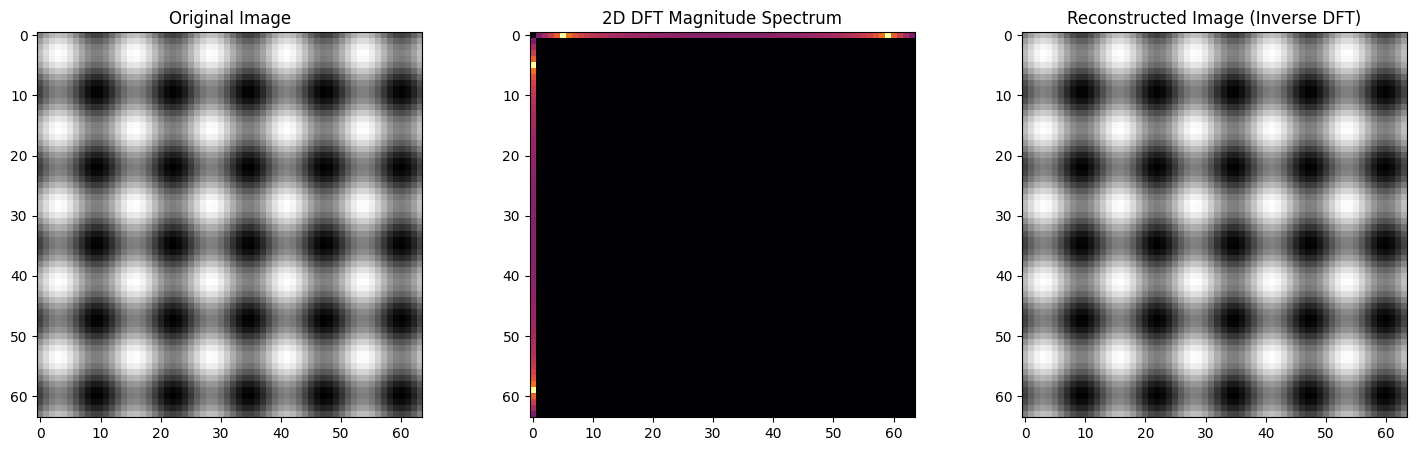

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load DFT 2D values from file
dft_2d_values = []
with open('dft_2d_output.txt', 'r') as f:
    for line in f:
        real, imag = map(float, line.strip().split(','))
        dft_2d_values.append(complex(real, imag))

dft_2d_values = np.array(dft_2d_values).reshape(64, 64)


# Load IDFT 2D values from file
idft_2d_values = []
with open('idft_2d_output.txt', 'r') as f:
    for line in f:
        real, imag = map(float, line.strip().split(','))
        idft_2d_values.append(complex(real, imag))

idft_2d_values = np.array(idft_2d_values).reshape(64, 64)

# Plot all results
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(np.log1p(np.abs(dft_2d_values)), cmap='inferno') # magnitude spectrum
ax[1].set_title('2D DFT Magnitude Spectrum')


ax[2].imshow(idft_2d_values.real, cmap='gray')
ax[2].set_title('Reconstructed Image (Inverse DFT)')

plt.show()


In [ ]:
import numpy as np

# Load DFT values from file
dft_2d_output = []
with open('dft_2d_output.txt', 'r') as f:
    for line in f:
        real, imag = map(float, line.strip().split(','))
        dft_2d_output.append(complex(real, imag))

dft_2d_output = np.array(dft_2d_output).reshape(64,64)

# Load IDFT values from file
idft_2d_output = []
with open('idft_2d_output.txt', 'r') as f:
    for line in f:
        real, imag = map(float, line.strip().split(','))
        idft_2d_output.append(complex(real, imag))
idft_2d_output = np.array(idft_2d_output).reshape(64,64)

# Example comparison (replace with your actual comparison logic)
# If you have a reference "correct" 2D DFT or IDFT, uncomment this code and adapt as needed.
if np.allclose(dft_2d_output, dft_result, atol=1e-2):
   print("DFT values are close")
else:
   print("DFT values are NOT close")

if np.allclose(idft_2d_output, image_reconstructed, atol=1e-2):
   print("IDFT values are close")
else:
   print("IDFT values are NOT close")

DFT values are close
IDFT values are close


### 3D FFT

Time taken:  57.872779846191406


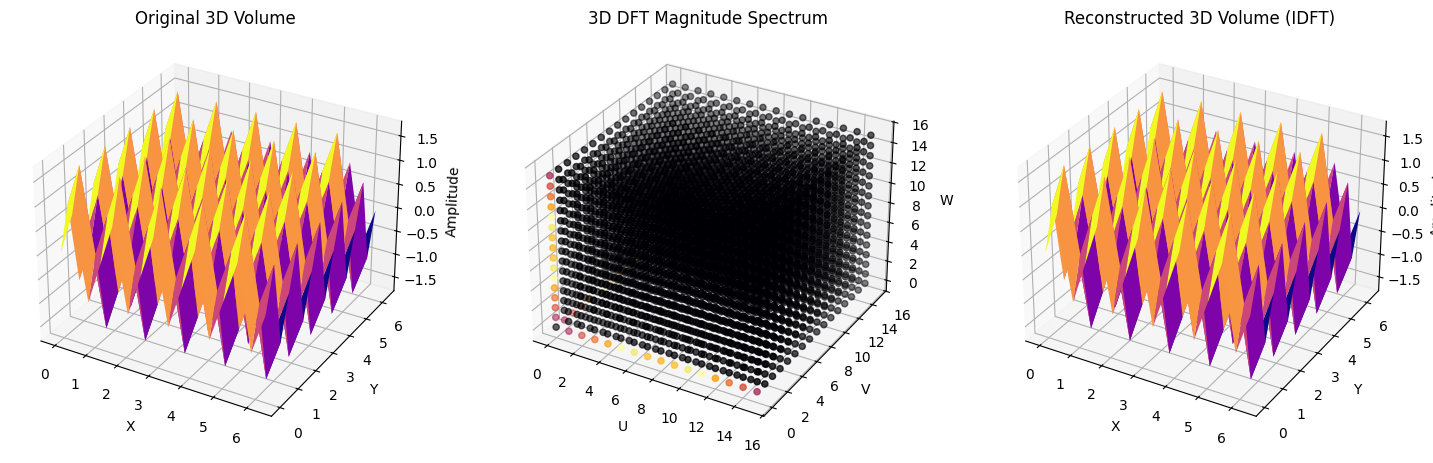

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

# Generate a 3D sine wave pattern as the input volume
N = 16  # Volume size (NxNxN)
x = np.linspace(0, 2 * np.pi, N)
y = np.linspace(0, 2 * np.pi, N)
z = np.linspace(0, 2 * np.pi, N)
X, Y, Z = np.meshgrid(x, y, z)
volume = np.sin(5 * X) + np.sin(5 * Y) + np.sin(5 * Z)  # Test volume

def dft3D(volume):
    N, M, P = volume.shape
    dft_result = np.zeros((N, M, P), dtype=complex)

    for u in range(N):
        for v in range(M):
            for w in range(P):
                sum_val = 0
                for x in range(N):
                    for y in range(M):
                        for z in range(P):
                            angle = -2j * np.pi * ((u * x / N) + (v * y / M) + (w * z / P))
                            sum_val += volume[x, y, z] * np.exp(angle)
                dft_result[u, v, w] = sum_val
    return dft_result

def idft3D(dft_result):
    N, M, P = dft_result.shape
    volume_reconstructed = np.zeros((N, M, P), dtype=complex)

    for x in range(N):
        for y in range(M):
            for z in range(P):
                sum_val = 0
                for u in range(N):
                    for v in range(M):
                        for w in range(P):
                            angle = 2j * np.pi * ((u * x / N) + (v * y / M) + (w * z / P))
                            sum_val += dft_result[u, v, w] * np.exp(angle)
                volume_reconstructed[x, y, z] = sum_val / (N * M * P)
    return volume_reconstructed.real

# Compute 3D DFT and Inverse DFT
start = time.time()
dft_result = dft3D(volume)
magnitude_spectrum = np.log1p(np.abs(dft_result))  # Log scale for visualization
volume_reconstructed = idft3D(dft_result)
end = time.time()
print("Time taken: ", end - start)

# 3D Plots
fig = plt.figure(figsize=(18, 6))

# 3D Plot of the Original Volume (Surface Plot)
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X[:, :, 0], Y[:, :, 0], volume[:, :, 0], cmap='plasma')
ax1.set_title('Original 3D Volume')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Amplitude')

# 3D Plot of the Magnitude Spectrum (Scatter Plot)
ax2 = fig.add_subplot(132, projection='3d')
coords = np.array(np.meshgrid(range(N), range(N), range(N))).T.reshape(-1, 3)
mags = magnitude_spectrum.flatten()
ax2.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=mags, cmap='inferno', marker='o')
ax2.set_title('3D DFT Magnitude Spectrum')
ax2.set_xlabel('U')
ax2.set_ylabel('V')
ax2.set_zlabel('W')

# 3D Plot of the Reconstructed Volume (Surface Plot)
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X[:, :, 0], Y[:, :, 0], volume_reconstructed[:, :, 0], cmap='plasma')
ax3.set_title('Reconstructed 3D Volume (IDFT)')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Amplitude')

plt.show()

In [25]:
%%writefile fft3d.cu

#include <stdio.h>
#include <cuComplex.h>
#include <math.h>
#include <cuda_runtime.h>

#define THREADS_PER_BLOCK 8  // 3D block size (8x8x8)

__global__ void dft3DKernel(cuComplex *input, cuComplex *output, int N, int M, int P, int inverse) {
    int u = threadIdx.x + blockIdx.x * blockDim.x;
    int v = threadIdx.y + blockIdx.y * blockDim.y;
    int w = threadIdx.z + blockIdx.z * blockDim.z;

    if (u >= N || v >= M || w >= P) return;

    cuComplex sum = make_cuComplex(0.0f, 0.0f);
    float sign = inverse ? 1.0f : -1.0f;

    for (int x = 0; x < N; x++) {
        for (int y = 0; y < M; y++) {
            for (int z = 0; z < P; z++) {
                float angle = sign * 2.0f * M_PI * (
                    (float)(u * x) / N +
                    (float)(v * y) / M +
                    (float)(w * z) / P
                );
                cuComplex expTerm = make_cuComplex(cosf(angle), sinf(angle));

                // Flattened 3D index
                int idx = x * M * P + y * P + z;
                cuComplex val = input[idx];
                sum = cuCaddf(sum, cuCmulf(val, expTerm));
            }
        }
    }

    if (inverse) {
        float norm = N * M * P;
        sum.x /= norm;
        sum.y /= norm;
    }

    output[u * M * P + v * P + w] = sum;
}

void computeDFT3D(cuComplex *d_input, cuComplex *d_output, int N, int M, int P, int inverse) {
    dim3 threadsPerBlock(THREADS_PER_BLOCK, THREADS_PER_BLOCK, THREADS_PER_BLOCK);
    dim3 numBlocks(
        (N + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK,
        (M + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK,
        (P + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK
    );

    dft3DKernel<<<numBlocks, threadsPerBlock>>>(d_input, d_output, N, M, P, inverse);
    cudaDeviceSynchronize();
}

void checkCudaError(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s - %s\n", msg, cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
}

int main() {
    int N = 16, M = 16, P = 16;  // Volume dimensions (reduced size for practicality)
    size_t size = N * M * P * sizeof(cuComplex);

    cuComplex *h_input = (cuComplex*)malloc(size);
    cuComplex *h_output = (cuComplex*)malloc(size);
    cuComplex *h_reconstructed = (cuComplex*)malloc(size);

    cuComplex *d_input, *d_output;
    checkCudaError(cudaMalloc((void**)&d_input, size), "cudaMalloc d_input failed");
    checkCudaError(cudaMalloc((void**)&d_output, size), "cudaMalloc d_output failed");

    // Initialize input: Example 3D sine wave function
    double start = 0.0;
    double end = 2.0 * M_PI;
    double step = (end - start) / (N - 1);

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < M; j++) {
            for (int k = 0; k < P; k++) {
                float x = start + i * step;
                float y = start + j * step;
                float z = start + k * step;
                int idx = i * M * P + j * P + k;
                h_input[idx] = make_cuComplex(sinf(5 * x) + sinf(5 * y) + sinf(5 * z), 0);
            }
        }
    }
    checkCudaError(cudaMemcpy(d_input, h_input, size, cudaMemcpyHostToDevice), "cudaMemcpy Host->Device failed");

    // Compute DFT
    computeDFT3D(d_input, d_output, N, M, P, 0);
    checkCudaError(cudaMemcpy(h_output, d_output, size, cudaMemcpyDeviceToHost), "cudaMemcpy Device->Host failed");

    // Compute Inverse DFT
    computeDFT3D(d_output, d_input, N, M, P, 1);
    checkCudaError(cudaMemcpy(h_reconstructed, d_input, size, cudaMemcpyDeviceToHost), "cudaMemcpy Device->Host failed");

    // Save results
    FILE *dftFile = fopen("dft_3d_output.txt", "w");
    FILE *idftFile = fopen("idft_3d_output.txt", "w");

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < M; j++) {
            for (int k = 0; k < P; k++) {
                int idx = i * M * P + j * P + k;
                fprintf(dftFile, "%f, %f\n", cuCrealf(h_output[idx]), cuCimagf(h_output[idx]));
                fprintf(idftFile, "%f, %f\n", cuCrealf(h_reconstructed[idx]), cuCimagf(h_reconstructed[idx]));
            }
        }
    }

    // Print CUDA error
    cudaError_t cudaErr = cudaGetLastError();
    if (cudaErr != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(cudaErr));
    }

    fclose(dftFile);
    fclose(idftFile);

    // Free memory
    free(h_input);
    free(h_output);
    free(h_reconstructed);
    cudaFree(d_input);
    cudaFree(d_output);

    return 0;
}

Overwriting fft3d.cu


In [26]:
!nvcc fft3d.cu -arch=sm_75 -o fft3d -lm
!time ./fft3d


real	0m0.241s
user	0m0.026s
sys	0m0.211s


In [27]:
N = 16  # Volume size (NxNxN)

expected_size = N * N * N

if count_lines('dft_3d_output.txt') != expected_size or count_lines('idft_3d_output.txt') != expected_size:
    raise ValueError("File does not have the expected number of values!")

# Load DFT values from file
dft_3d_output = []
with open('dft_3d_output.txt', 'r') as f:
    for line in f:
        real, imag = map(float, line.strip().split(','))
        dft_3d_output.append(complex(real, imag))
dft_3d_output = np.array(dft_3d_output).reshape(N, N, N)

# Load IDFT values from file
idft_3d_output = []
with open('idft_3d_output.txt', 'r') as f:
    for line in f:
        real, imag = map(float, line.strip().split(','))
        idft_3d_output.append(complex(real, imag))
idft_3d_output = np.array(idft_3d_output).reshape(N, N, N)

# Compare saved values with computed values
if np.allclose(dft_3d_output, dft_result, atol=1e-2):
    print("DFT values are close")
else:
    print("DFT values are NOT close")

if np.allclose(idft_3d_output, volume_reconstructed, atol=1e-2):
    print("IDFT values are close")
else:
    print("IDFT values are NOT close")


DFT values are close
IDFT values are close
